In [0]:
!pip install fastai2 -q

In [0]:
from fastai2.vision.all import *

This mainly contains the different ways we can use the POWERFUL DATABLOCKS api to bring in data.   
Download the dataset and give it try. There are a few ways to do this so the ways i have done it may not be the only way (and not the best way ).  
In the `more` you can see where the whole solution ie `datablocks + learner` code is available.  
[First resourse to checkout are the tutorials](https://github.com/fastai/fastai2/blob/master/nbs/50_tutorial.datablock.ipynb)

Curretly we'll focus on how how we can use source(paths or dfs) and set out get_x, get_y, get_items.  
Splitters and Item/Batch Tfms - will update later

# Classification

## Single label classification   
(ImageBlock(cls=PILImageBW), CategoryBlock

In [8]:
path = untar_data(URLs.MNIST_TINY)
!ls {path}

labels.csv  models  test  train  valid


In [15]:
df = pd.read_csv(path/'labels.csv')
df.head(2)

,name,label
0,train/3/7463.png,3
1,train/3/9829.png,3


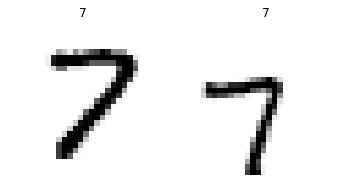

In [50]:
mnist = DataBlock(blocks=(ImageBlock(cls=PILImageBW), CategoryBlock),
                  get_x=ColReader(0, pref=f'{path}/'),
                  get_y=ColReader(1),
                  splitter =RandomSplitter(),
                  item_tfms = [CropPad(34),RandomCrop(28)],
                  batch_tfms = [Normalize()],
                  )
dl = mnist.dataloaders(df)
dl.show_batch(max_n=2)

### Experiments, high level understanding

1) Let's change `ImageBlock(cls=PILImageBW)` to `ImageBlock()`

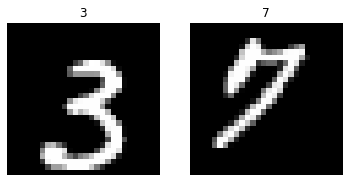

In [51]:
mnist = DataBlock(blocks=(ImageBlock(), CategoryBlock),
                  get_x=ColReader(0, pref=f'{path}/'),
                  get_y=ColReader(1),
                  splitter =RandomSplitter(),
                  item_tfms = [CropPad(34),RandomCrop(28)],
                  batch_tfms = [Normalize()],
                  )
dls = mnist.dataloaders(df)
dls.show_batch(max_n=2)

Wow that seems to work too.We see '3' and '7'
Hang on it looks different though, the colors are inverted.  
TODO:This shouldn't effect the training of the model(haven't tried it out).   
Let's look at ImageBlock. (??ImageBlock)
```
def ImageBlock(cls=PILImage):
    "A `TransformBlock` for images of `cls`"
    return TransformBlock(type_tfms=cls.create, batch_tfms=IntToFloatTensor)
```
The default cls is PILImage which is an RGB image. For single channel images you want to pass cls=PILImageBW. Later we'll see how we pass in a 4-channel image.
Other thing to notice in the code is `batch_tfms=IntToFloatTensor`, we'll discuss that shortly.

2) Change CategoryBlock to  CategoryBlock()

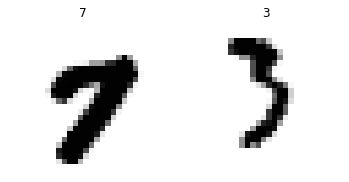

In [33]:
mnist = DataBlock(blocks=(ImageBlock(cls=PILImageBW), CategoryBlock()),
                  get_x=ColReader(0, pref=f'{path}/'),
                  get_y=ColReader(1),
                  splitter =RandomSplitter(),
                  item_tfms = [CropPad(34),RandomCrop(28)],
                  batch_tfms = [Normalize()],
                  )
dls = mnist.dataloaders(df)
dls.show_batch(max_n=2)

This looks good. The answer is in ??DataBlock.  
`blocks = L(b() if callable(b) else b for b in blocks)`

3)What are the batch tranforms that are being applied?   
We asked for `Normalize`. Let's check

In [56]:
dls.train.after_batch

Pipeline: IntToFloatTensor -> Normalize

Rememeber what we saw in ??ImageBlock - `batch_tfms=IntToFloatTensor`.   
That is being applied automatically for us.     
So now replace ` batch_tfms = [Normalize()]` with ` batch_tfms = [IntToFloatTensor(),Normalize()]`. It should all be good.   
But wait, didn't we apply `IntToFloatTensor`  twice ? Don't worry duplicates are removed look at `_merge_tfms` in `block.py`.    
So the different `TransformBlocks`  may have different default type_tfms, item_tfms, batch_tfms. 

Similarly `ToTensor()` is applied automatically for `item_tfms`.   
```
        self.type_tfms  =            L(type_tfms)
        self.item_tfms  = ToTensor + L(item_tfms)
        self.batch_tfms =            L(batch_tfms)
```

## Now lets try the same thing with get_items

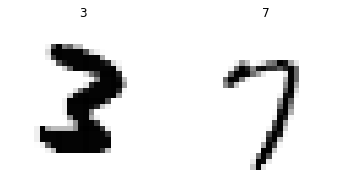

In [62]:
def _mnist_items(x): 
  return (f'{path}/'+x.name,x.label)

mnist = DataBlock.from_columns(blocks=(ImageBlock(cls=PILImageBW), CategoryBlock),
                  get_items = _mnist_items,
                  splitter =RandomSplitter(),
                   )
dls = mnist.dataloaders(df)
dls.show_batch(max_n=2)

Note: i always forget the `from_columns` in `DataBlock.from_columns` 


### What is `_mnist_items`, how to build it?

We need a x and y to train. More specifically we need a Tuple ie (x,y).    
We have to get this from our df.  
Our x are image names in column 'name'.(we need the full path to grab the image from)   
Our y are the labels in column 'labels'.  

See what `_mnist_items(df)` gives you.   

In [0]:
df.name, df.label

In [87]:
df.values

array([['train/3/7463.png', 3],
       ['train/3/9829.png', 3],
       ['train/3/7881.png', 3],
       ...,
       ['valid/7/0.png', 7],
       ['valid/7/8282.png', 7],
       ['valid/7/7149.png', 7]], dtype=object)

Explanation ..... TODO

# Predict a list of numbers. 
(ImageBlock, RegressionBlock(c_out=4)   
`(image_id,	[healthy	multiple_diseases	rust	scab])`.  
Look at show_batch so see the particular case

Here we deal with a single leaf image and we have to predict wether the leaf is healthy, has multiple diseases, has rust, has scab.   
So one input image and 4 columns to predict.  
In the [evaluation](https://www.kaggle.com/c/plant-pathology-2020-fgvc7/overview/evaluation) we have `For each image_id in the test set, you must predict a probability for each target variable. ` so we'll set it up as a regression problem.   
The [data](https://www.kaggle.com/c/plant-pathology-2020-fgvc7/data) is available here.
TODO: upload tiny data

In [0]:
path= '''drive/My Drive/kaggle/plant/''' 

In [113]:
train = pd.read_csv(path+'train.csv')
train.head(2)

,image_id,healthy,multiple_diseases,rust,scab
0,Train_0,0,0,0,1
1,Train_1,0,1,0,0


We need to create a tuple is `(x,y)` for our model to train. So we'll create like this `(image_id,	[healthy	multiple_diseases	rust	scab])`Let's create a new column `combined` which is a list of the dependent variables. (This is not the only way to solve this problem)

In [114]:
train['combined'] = train[['healthy','multiple_diseases','rust','scab']].values.tolist()
train.head(2)

,image_id,healthy,multiple_diseases,rust,scab,combined
0,Train_0,0,0,0,1,"[0, 0, 0, 1]"
1,Train_1,0,1,0,0,"[0, 1, 0, 0]"


### 'show_batch' fixes to show a list (not yet perect)
For `show_batch` to work we need to add the ability for a list to have `show_title`

In [0]:
class TitledList(list, ShowTitle):
    _show_args = {'label': 'text'}
    def show(self, ctx=None, **kwargs):
        "Show self"
        return show_title(self, ctx=ctx, **merge(self._show_args, kwargs))

In [0]:
class ToListTensor(Transform):
    "Transform to int tensor"
    # order = 10 #Need to run after PIL transforms on the GPU
    _show_args = {'label': 'text'}
    def __init__(self, split_idx=None,):
        super().__init__(split_idx=split_idx)

    def encodes(self, o): return o
    # def decodes(self, o): return TitledNumberShort(o)
    def decodes(self, o): return TitledList(o)

Independent variable is the image we'll use a ImageBlock.   
Dependent varaible we'll use a RegressionBlock, here we need to set `c_out`.  
And we add `ToListTensor` to the `get_y`

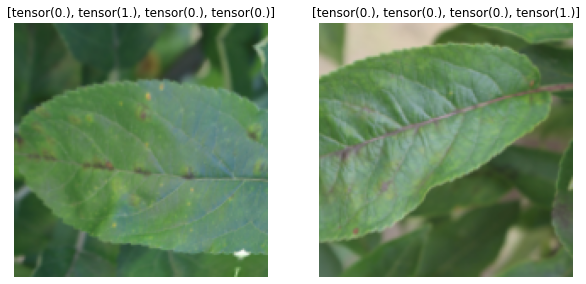

In [116]:
plant = DataBlock(blocks =(ImageBlock, RegressionBlock(c_out=4)),
                  get_x = ColReader('image_id', pref=f'drive/My Drive/kaggle/plant/images/',suff='.jpg'),
                  get_y = [ColReader('combined'),ToListTensor],
                  splitter =RandomSplitter(),
                  item_tfms=[Resize(150)],
                  batch_tfms = [*aug_transforms()],
                  )
dls = plant.dataloaders(train)
dls.show_batch(nrows=1,ncols=2,figsize=(10,10))

I have a full pipeline here [here](https://github.com/muellerzr/Practical-Deep-Learning-for-Coders-2.0/blob/master/Computer%20Vision/06_Multi_Point_Regression.ipynb)

# 4 channel input image    

[Kaggle Competition](https://www.kaggle.com/c/human-protein-atlas-image-classification)   
This was worked on by a group of us look here for the write-up - ????
@akashpalrecha, @aman, @init_27 (am i missing anyone else please let me know)  

Each image in the dataset is a single channel black and white image.  
We need to combine 4 of them to make a 4-channel image.   
Given this 4-channel image we want to predict multiple categories.  

We have:
fname_red.png  
fname_green.png  
fname_blue.png   
fname_yellow.png  
This four need to be stacked to form one single 4-channeled image.  
This gives a clear understanding of when to use get_items, get_x, get_y.


In [0]:
data_path = Path('/storage/data/atlas/train')
files = get_image_files(data_path)

In [0]:
def custom_get(path):#files are in sets of four
    files = get_image_files(path)
    files = sorted(files)
    return files[slice(0, len(files), 4)]

In [0]:
def comb_4img(fname):#combine four 1-channel image to get one 4-channel image
    fname = str(fname)
    suffix = '.png'

    if fname.endswith('.png') or fname.endswith('.tif'):
        suffix = fname[-4:]
        fname = fname.split('_')[0]

    colors = ['red','green','blue','yellow']
    img = [Image.open(fname+'_'+color+suffix) for color in colors]
    
    x = np.stack(img, axis=-1)
    return PILImage.create(x)

In [0]:
df = pd.read_csv("../data/atlas/train.csv")
df.set_index("Id", inplace=True)

def get_y(path, df=df):
    path = Path(path)
    path = path.stem
    path = path[:-5]
    return df.loc[path].values[0].split(" ")

In [0]:
atlas = DataBlock(blocks=(ImageBlock, MultiCategoryBlock),
                  get_items=custom_get, 
                  get_x=comb_4img,
                  get_y=get_y
                 )
dls = atlas.dataloaders(data_path,bs=2)
dls.show_batch()

In [0]:
getters example 

In [0]:
SO we need a get_items to get the files, get_x, get_y for (x,y).   
Some times no get_x, why ?   what happens if you add get_x to that mnist_tiny example

## 1-ch vs 3-ch 

In [126]:
fn

(#1428) [Path('/root/.fastai/data/mnist_tiny/train/3/9153.png'),Path('/root/.fastai/data/mnist_tiny/train/3/9324.png'),Path('/root/.fastai/data/mnist_tiny/train/3/8830.png'),Path('/root/.fastai/data/mnist_tiny/train/3/9621.png'),Path('/root/.fastai/data/mnist_tiny/train/3/7862.png'),Path('/root/.fastai/data/mnist_tiny/train/3/8075.png'),Path('/root/.fastai/data/mnist_tiny/train/3/8816.png'),Path('/root/.fastai/data/mnist_tiny/train/3/8227.png'),Path('/root/.fastai/data/mnist_tiny/train/3/715.png'),Path('/root/.fastai/data/mnist_tiny/train/3/7067.png')...]

In [127]:
net = resnet18(pretrained=True,)

Downloading: "https://download.pytorch.org/models/resnet18-5c106cde.pth" to /root/.cache/torch/checkpoints/resnet18-5c106cde.pth


In [131]:
net.conv1.weight.shape

torch.Size([64, 3, 7, 7])